# Regression example using TabSRALinear: *Synthetic* 1 dataset


$$y  = 5x_1-5x_2$$




## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [5]:
sys.path.append('../')
from SRAModels import TabSRALinear,LR
from utils import TrainRegressionModel,reset_seed_,Predict, load, save,LinearScaling


## Data

In [6]:
np.random.seed(42)
x1 = np.random.normal(0,1,3*10000)
x2 = np.random.normal(0,1,3*10000)
x3 = np.random.normal(0,1,3*10000)
x4 = np.random.normal(0,1,3*10000)
x5 = np.random.normal(0,1,3*10000)
X = np.concatenate((x1.reshape(-1,1), x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1)  ),axis=1)

In [7]:
odd = 5*x1-5*x2
y_c = 1/(1+np.exp(-odd))
y = np.where(y_c>0.5, 1,0)
X_train_,X_test_,Y_train_,Y_test_ = train_test_split(X,odd,stratify =y , random_state=42)
n_features, n_classes = 5,1
len(Y_train_),len(Y_test_)

(22500, 7500)

In [8]:
feature_names = ['x1','x2','x3','x4','x5']
df_test = pd.DataFrame(X_test_,columns=feature_names)
df_test['y'] = Y_test_
df_test.head()

,x1,x2,x3,x4,x5,y
0,1.987276,1.177705,-0.248466,-0.644142,-0.890501,4.047853
1,0.997266,-0.694594,-0.447051,-0.581979,-0.214629,8.459300
2,1.447306,1.030847,-0.796111,0.923338,-0.852372,2.082293
3,-1.333432,-0.780459,-1.403931,0.402760,0.597125,-2.764867
4,-0.467701,-2.232282,0.954899,-0.952536,0.014282,8.822903


## Model: LR (Linear Regression)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train_), torch.Tensor(Y_train_))
val_set = torch.utils.data.TensorDataset(torch.Tensor(X_test_), torch.Tensor(Y_test_))

In [11]:
## function to build the model
def buildLR(static_params):
    Model = LR(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   bias = static_params['bias'],
                   for_classif=False
                  )
    return Model

In [12]:
static_params_LR = {'dim_input':n_features, 'dim_output':n_classes, 'bias':True}

In [13]:
%%time
reset_seed_(45)
SimpleLR = buildLR(static_params_LR)
save_model_dir= f'LR_Synthetic1'
SimpleLR = TrainRegressionModel(SimpleLR, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= 150,
                   batch_size = 256,
                   lr = 0.5*1e-2,
                   eval_every = 5,
                   weight_decay = 0.0,
                   verbose=1,
                   load_best_eval=True
                   )

epoch = 0--rmse perf = 6.884404182434082
epoch = 5--rmse perf = 4.244494438171387
epoch = 10--rmse perf = 2.292414903640747
epoch = 15--rmse perf = 1.029119849205017
epoch = 20--rmse perf = 0.36168816685676575
epoch = 25--rmse perf = 0.09268835186958313
epoch = 30--rmse perf = 0.01615552045404911
epoch = 35--rmse perf = 0.0017305311048403382
epoch = 40--rmse perf = 0.00010099023347720504
epoch = 45--rmse perf = 3.6084005841985345e-05
epoch = 50--rmse perf = 2.8729549740091898e-05
epoch = 55--rmse perf = 2.370581751165446e-05
epoch = 60--rmse perf = 1.807405351428315e-05
epoch = 65--rmse perf = 1.5031890143291093e-05
epoch = 70--rmse perf = 1.2366760529403109e-05
epoch = 75--rmse perf = 9.694508662505541e-06
epoch = 80--rmse perf = 7.697808541706763e-06
epoch = 85--rmse perf = 5.68485938856611e-06
epoch = 90--rmse perf = 4.021849690616364e-06
epoch = 95--rmse perf = 4.008942596556153e-06
epoch = 100--rmse perf = 2.6871589398069773e-06
epoch = 105--rmse perf = 2.4527353161829524e-06
epoc

In [14]:
pred_tab_lr = Predict(SimpleLR,val_set[:][0],device=device)
rmse = np.sqrt(mean_squared_error(Y_test_, pred_tab_lr))
r2 = r2_score(Y_test_, pred_tab_lr) 
print(f"--RMSE perf = {rmse} -- r2 perf = {r2}")

--RMSE perf = 2.88894620229126e-07 -- r2 perf = 0.9999999999999983


## Model: TabSRALinear 

In [15]:
## function to build the model
def buildTabSRA(config_opt,static_params):
    Model = TabSRALinear(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   dim_head = config_opt['dim_head'],
                   get_attention = static_params['get_attention'],
                   dropout_rate = config_opt['dropout_rate'],
                   activation = static_params['activation'],
                   bias = static_params['bias'],
                   s =  LinearScaling(scale = config_opt['dim_head']**-0.5),
                   for_classif=False
                  )
    return Model

In [16]:
## The hyperparameters are already optimized (using optuna) 
config_opt = {'lr': 1e-2, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 150, 'weight_decay': 1e-6, 'batch_size': 256}
static_params = {'dim_input':n_features, 'dim_output':n_classes,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}


In [17]:
%%time
reset_seed_(45)
Model = buildTabSRA(config_opt,static_params)
save_model_dir= f'TabSRALinear_Synthetic1'
Model = TrainRegressionModel(Model, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= config_opt['epochs'],
                   batch_size = config_opt['batch_size'],
                   lr = config_opt['lr'],
                   eval_every = 5,
                   weight_decay = config_opt['weight_decay'],
                   verbose=1,
                   load_best_eval=True
                   )

epoch = 0--rmse perf = 5.017448902130127
epoch = 5--rmse perf = 1.095186471939087
epoch = 10--rmse perf = 0.420963317155838
epoch = 15--rmse perf = 0.1840617060661316
epoch = 20--rmse perf = 0.08755578845739365
epoch = 25--rmse perf = 0.04758859798312187
epoch = 30--rmse perf = 0.026745770126581192
epoch = 35--rmse perf = 0.019157808274030685
epoch = 40--rmse perf = 0.016084065660834312
epoch = 45--rmse perf = 0.015772594138979912
epoch = 50--rmse perf = 0.012751785106956959
epoch = 55--rmse perf = 0.003232835326343775
epoch = 60--rmse perf = 0.0018082367023453116
epoch = 65--rmse perf = 0.0014283116906881332
epoch = 70--rmse perf = 0.0012470759684219956
epoch = 75--rmse perf = 0.0011333581060171127
epoch = 80--rmse perf = 0.0010420597391203046
epoch = 85--rmse perf = 0.0009992370614781976
epoch = 90--rmse perf = 0.0009555491851642728
epoch = 95--rmse perf = 0.0009256432531401515
epoch = 100--rmse perf = 0.0009105454082600772
epoch = 105--rmse perf = 0.0009027844062075019
epoch = 110--

In [18]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
att,pred_tabsra = Predict(Model,val_set[:][0],device=device)

rmse_tabsra = np.sqrt(mean_squared_error(Y_test_, pred_tabsra))
r2_tabsra = r2_score(Y_test_, pred_tabsra) 
print(f"--RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")

--RMSE perf = 0.0008480922252009112 -- r2 perf = 0.9999999853083327


In [19]:
Model.classifier.weight

Parameter containing:
tensor([[ 5.0002, -5.0004,  2.6855,  2.8324,  2.9348]], device='cuda:0',
       requires_grad=True)

## Model: XGBoost 

In [20]:
from xgboost import XGBRegressor


/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [21]:
def buildXGBoost(config_opt,static_params):
    config_opt.update(static_params)
    model_xgb = XGBRegressor(**config_opt)
    return model_xgb

In [22]:
### These parameters are optimized using 30 trials with optuna (bayesian optimization)
config_opt_xgb = {
              'eta': 0.03425616464106714,
              'max_depth': 5,
              'colsample_bytree': 1.0,
              'subsample': 1.0,
              'n_estimators': 1100,
              'min_child_weight':56

              }
static_params_xgb = {
                 'random_state':45,
                 'n_jobs': -1,
}


In [23]:
%%time
model_xgb = buildXGBoost(config_opt=config_opt_xgb,static_params=static_params_xgb)
eval_set = [(X_test_, Y_test_)]
model_xgb.fit(X_train_, Y_train_, eval_metric=['rmse'], eval_set=eval_set, verbose=1)

[0]	validation_0-rmse:6.78971
[1]	validation_0-rmse:6.57419
[2]	validation_0-rmse:6.36619
[3]	validation_0-rmse:6.16510
[4]	validation_0-rmse:5.97092
[5]	validation_0-rmse:5.78337
[6]	validation_0-rmse:5.60209
[7]	validation_0-rmse:5.42513
[8]	validation_0-rmse:5.25594
[9]	validation_0-rmse:5.09058
[10]	validation_0-rmse:4.93219
[11]	validation_0-rmse:4.77672
[12]	validation_0-rmse:4.62745
[13]	validation_0-rmse:4.48231
[14]	validation_0-rmse:4.34313
[15]	validation_0-rmse:4.20775
[16]	validation_0-rmse:4.07679
[17]	validation_0-rmse:3.95085
[18]	validation_0-rmse:3.82735
[19]	validation_0-rmse:3.70955
[20]	validation_0-rmse:3.59369
[21]	validation_0-rmse:3.48386
[22]	validation_0-rmse:3.37553
[23]	validation_0-rmse:3.27260
[24]	validation_0-rmse:3.17170
[25]	validation_0-rmse:3.07494
[26]	validation_0-rmse:2.98009
[27]	validation_0-rmse:2.88885
[28]	validation_0-rmse:2.80179
[29]	validation_0-rmse:2.71563
[30]	validation_0-rmse:2.63371
[31]	validation_0-rmse:2.55299
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             eta=0.03425616464106714, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.034256164,
             max_delta_step=0, max_depth=5, min_child_weight=56, missing=nan,
             monotone_constraints='()', n_estimators=1100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=45,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
# Inference for xgboost 
pred_xgboost = model_xgb.predict(X_test_)
best_rmse_xgb = np.sqrt(mean_squared_error(Y_test_, pred_xgboost) )
best_r2_xgb = r2_score(Y_test_, pred_xgboost) 
print(f"--RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")

--RMSE perf = 0.24291824682524243 -- r2 perf = 0.998794672132331


## Interpretability: using feature attribution on the test data

- For Linear Regression, the effect is given by $\beta\odot x$ where $\beta$ is the regression coefficients.
- For TabSRALinear, the feature attribution vector is $\beta\odot a\odot x$ where $\beta$ is the linear regression coefficients, $a$ the SRA attention weights $\in [0,1]$ and $x$ the input vector.
- For XGBoost, we will use TreeSHAP https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html to get the feature attribution.

In [25]:
%%time
attributions_lr = pd.DataFrame(SimpleLR.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_lr.columns = feature_names
attributions_lr['pred'] = pred_tab_lr
attributions_lr['label'] = val_set[:][1].numpy()

CPU times: user 19.2 ms, sys: 11 ms, total: 30.3 ms
Wall time: 2.1 ms


In [26]:
%%time
attributions_tabsra = pd.DataFrame(att*Model.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_tabsra.columns = feature_names
attributions_tabsra['pred'] = pred_tabsra
attributions_tabsra['label'] = val_set[:][1].numpy()

CPU times: user 16.4 ms, sys: 9.37 ms, total: 25.7 ms
Wall time: 1.62 ms


In [27]:
%%time
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred'] = pred_xgboost
attributions_xgb['label'] = val_set[:][1].numpy()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 20.1 s, sys: 1.71 s, total: 21.8 s
Wall time: 1.83 s


LR --RMSE perf = 2.88894620229126e-07 -- r2 perf = 0.9999999999999983


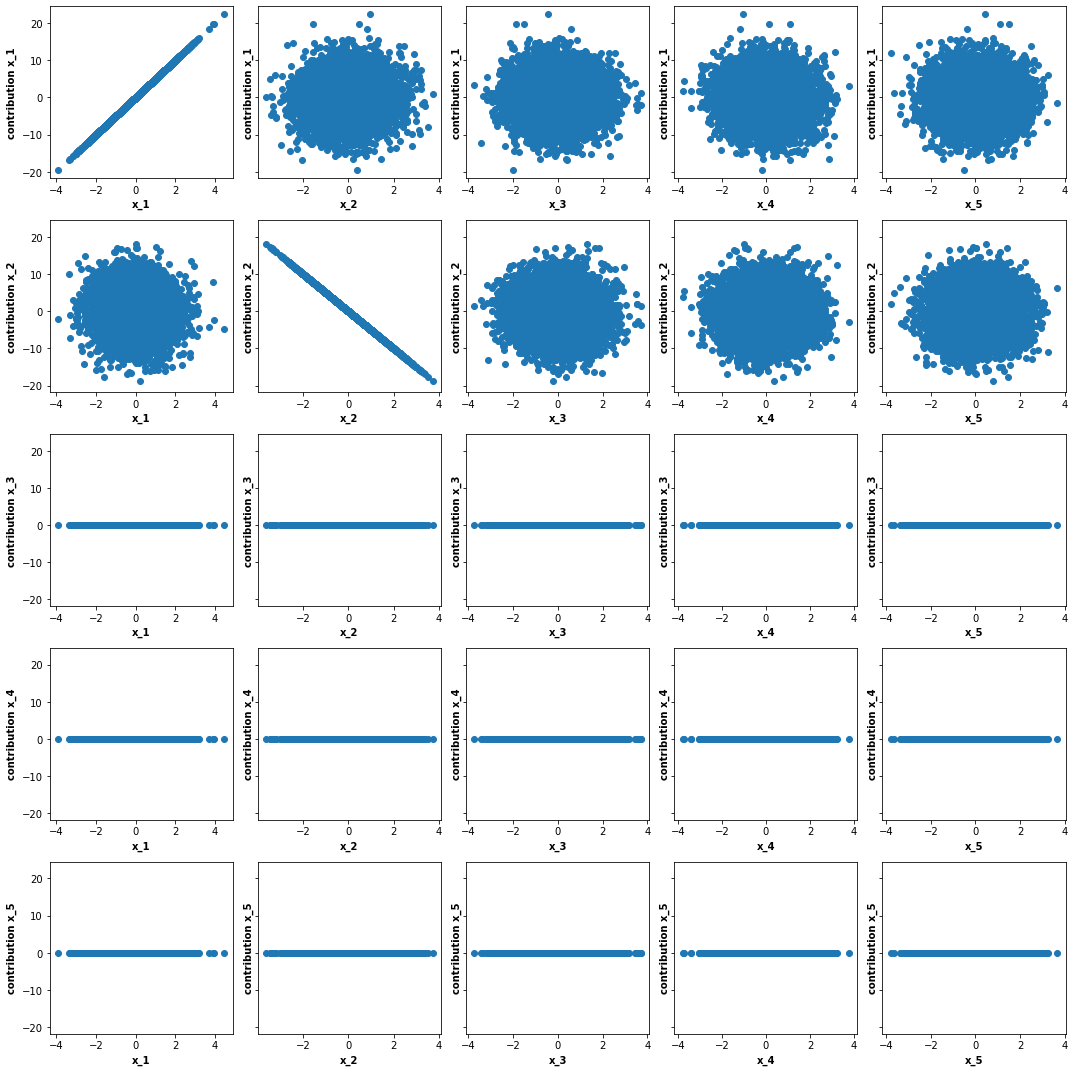

In [28]:
print(f"LR --RMSE perf = {rmse} -- r2 perf = {r2}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_lr[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

TabSRALinear --RMSE perf = 0.0008480922252009112 -- r2 perf = 0.9999999853083327


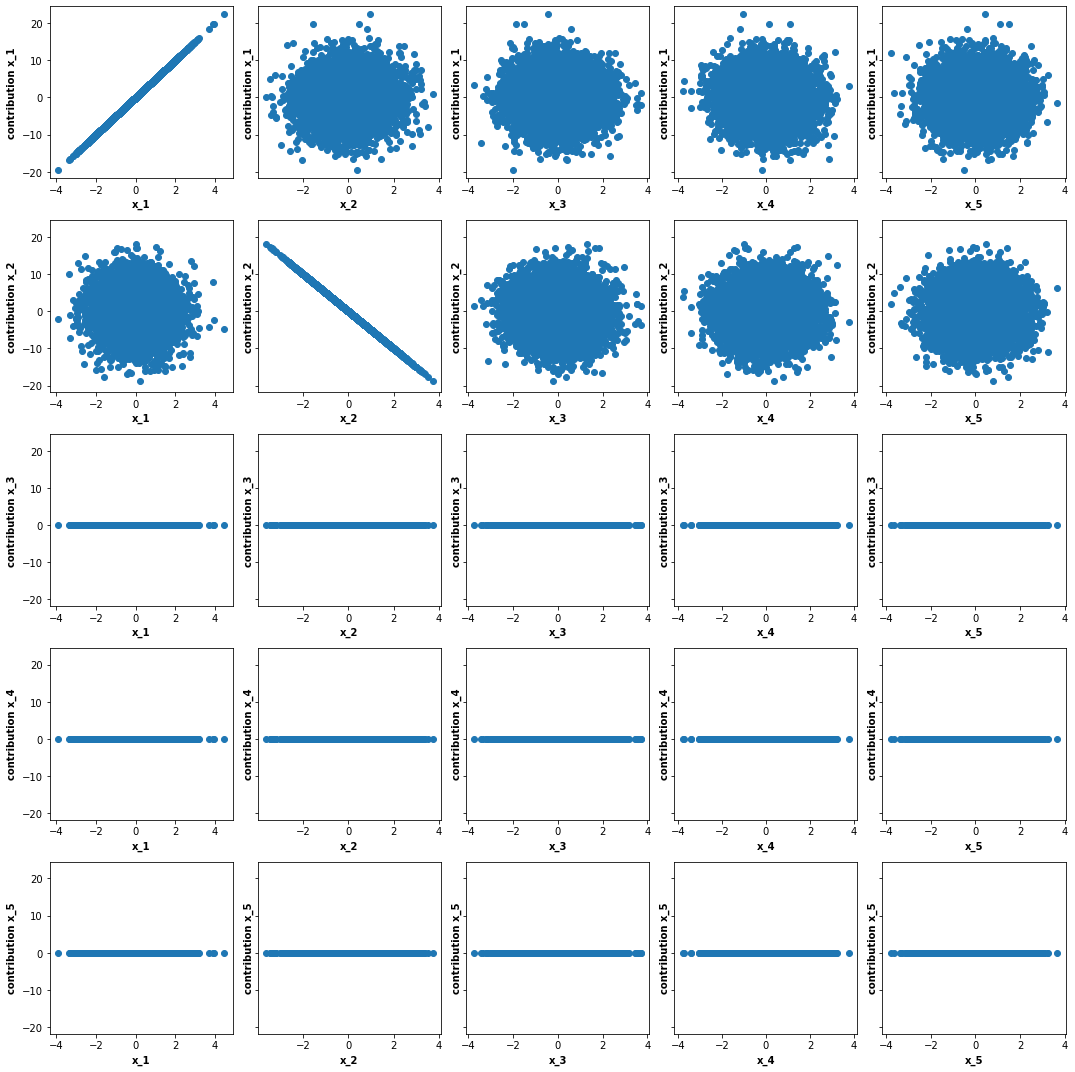

In [29]:
print(f"TabSRALinear --RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_tabsra[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

XGBoost --RMSE perf = 0.24291824682524243 -- r2 perf = 0.998794672132331


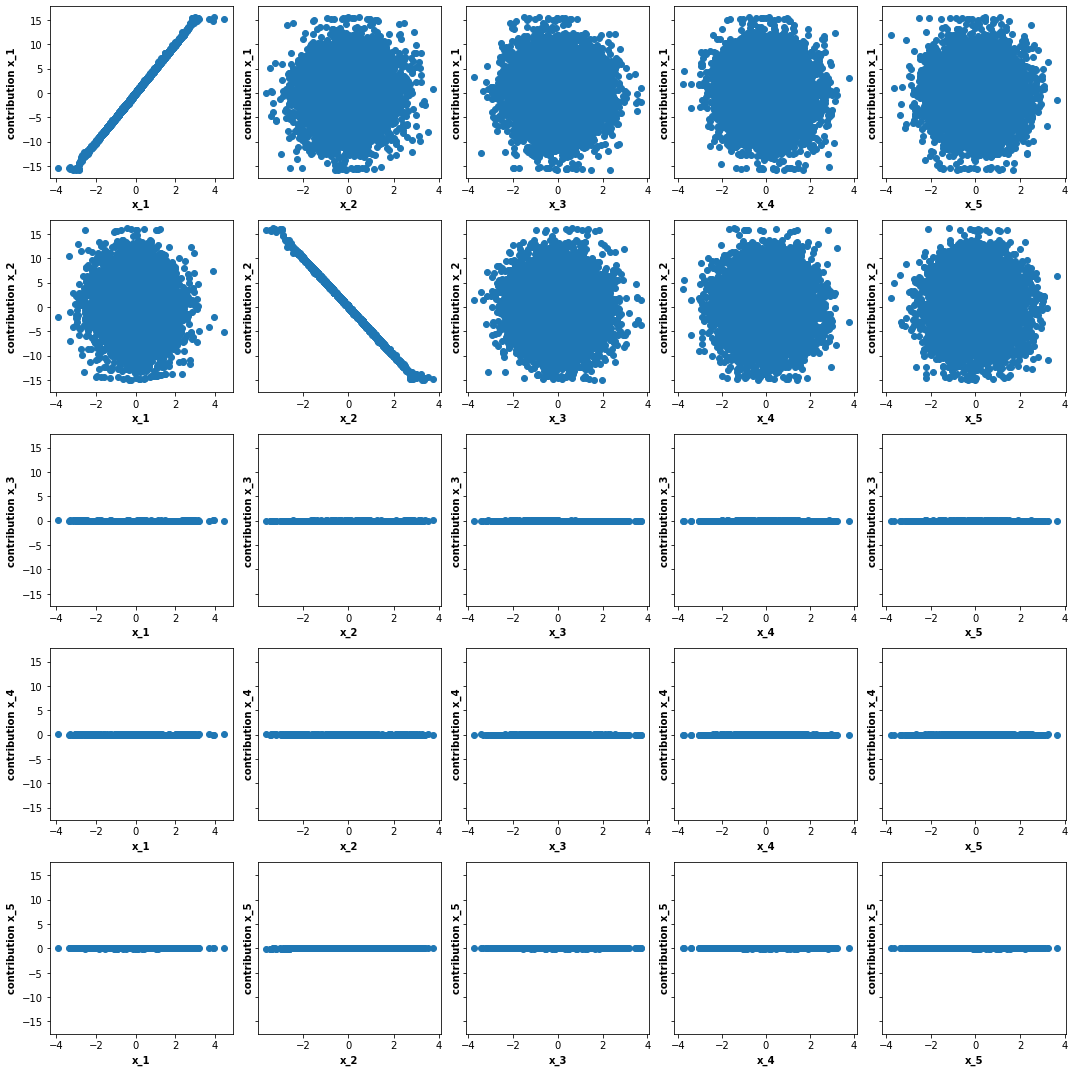

In [30]:
print(f"XGBoost --RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_xgb[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

## Identification of important features

We consider all the test set and only $x_1$ and $x_2$ are relevant among $(x_1, x_2, x_3, x_4, x_5)$. 

In [33]:
precision_lr = np.argsort(attributions_lr[['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0,1]).intersection(set(x[3:5]))),axis=1)
precision_lr.mean()/2

1.0

In [34]:
precision_tabsra = np.argsort(attributions_tabsra[['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0,1]).intersection(set(x[3:5]))),axis=1)
precision_tabsra.mean()/2

1.0

In [35]:
precision_xgb= np.argsort(attributions_xgb[['x1','x2','x3','x4','x5']].abs()).apply(lambda x: len(set([0,1]).intersection(set(x[3:5]))),axis=1)
precision_xgb.mean()/2

0.9997333333333334